In [1]:
import torch
from torch import nn
import torch.optim as optim

import pickle

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [21]:
# Open the files:
train_fh = open('lego-train.pickle', 'rb')
test_fh = open('lego-test.pickle', 'rb')


train_data = pickle.load(train_fh)
test_data = pickle.load(test_fh)

# train_data -> [] of tuples: (ndarray, uint8 label) 

train_data_X = [img for (img, _) in train_data]
train_data_y = [lbl for (_, lbl) in train_data]

test_data_X = [img for (img, _) in test_data]
test_data_y = [lbl for (_, lbl) in test_data]

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)
])

def get_dataset(X, y):
    tensor_x = torch.stack([img_transforms(img) for img in X])
    tensor_y = torch.Tensor(y).long()

    dataset = TensorDataset(tensor_x, tensor_y)  
    return dataset

train_dataset = get_dataset(train_data_X, train_data_y)
test_dataset = get_dataset(test_data_X, test_data_y)

In [4]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

In [5]:
#Разделение данных на изображения и соответствующие им метки

In [10]:
# For humans:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick', '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles', '1x2 Grill']


Original shape is  torch.Size([48, 48, 1])


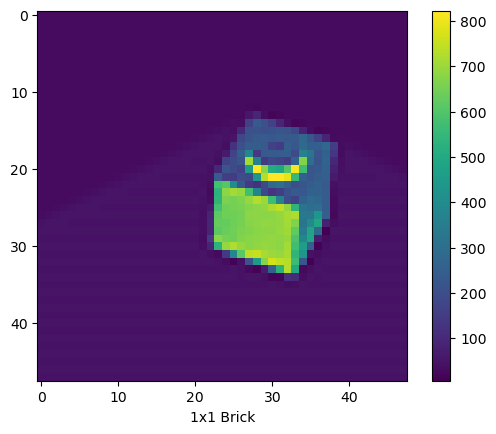

In [11]:
# the same, but with torch dataset
train_dataloader = DataLoader(train_dataset)
images_data, label_data = next(iter(train_dataloader)) 

print('Original shape is ', images_data[0].shape)
plt.figure()
plt.imshow(images_data[0].numpy())
plt.colorbar()
plt.xlabel(class_names[label_data])
plt.show()

In [33]:
import torch.nn.functional as F
import torch
from torch import nn, optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [49]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(64 * 12 * 12, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = x.reshape(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [50]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [51]:
def get_dataset(X, y, batch_size):
    tensor_x = torch.Tensor(X)
    tensor_y = torch.Tensor(y).long()
    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


train_fh = open('lego-train.pickle', 'rb')
test_fh = open('lego-test.pickle', 'rb')

train_data = pickle.load(train_fh)
test_data = pickle.load(test_fh)

train_data_X = [img for (img, _) in train_data]
train_data_y = [lbl for (_, lbl) in train_data]

test_data_X = [img for (img, _) in test_data]
test_data_y = [lbl for (_, lbl) in test_data]

# Рассчитываем среднее и стандартное отклонение для нормализации
mean = np.mean(train_data_X)
std = np.std(train_data_X)

# Трансформации для изображений
img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Применение трансформаций к датасетам
train_dataset = get_dataset(train_data_X, train_data_y, batch_size=32)
test_dataset = get_dataset(test_data_X, test_data_y, batch_size=32)

In [52]:
net_cnn = CNN()
net_cnn.apply(init_weights)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_cnn.to(device)

num_epochs = 100
learning_rate = 0.001

In [53]:
def train(net, train_loader, device, num_epochs, learning_rate):
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:
        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                inputs = inputs.permute(0, 3, 1, 2).to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct / batch_total

                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            acc = correct / total 
            acc_history.append(acc)

    pbar.close()
    return acc_history

Epoch: 99, Batch: 14, Loss: 4.79, Acc: 1.00: 100%|█| 1500/1500 [02:05<00:00, 11.


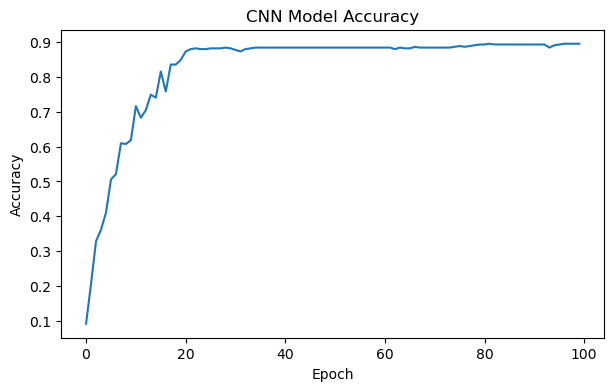

In [54]:
hist_cnn = train(net_cnn, train_dataset, device, num_epochs, learning_rate)

plt.figure(figsize=(7, 4))
plt.plot(hist_cnn)
plt.title("CNN Model Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()